In [1]:
#Data handling
import h5py
#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns


#Mathematical libraries
import numpy as np
import scipy.stats as stats
import bottleneck
import statsmodels.api as sm
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from scipy.sparse import csr_matrix
from scipy import sparse
import pickle
import subprocess
import itertools


In [ ]:
def parse_pdist(filename):
    """
    Loads data in file to dataframe.
    """
    col_uid = []
    row_uid = []
    with h5py.File(filename, 'r') as f:

        jac_structure = f['jac_structure'][:]
        jac_go = f['jac_go'][:]
        exp_condensed = f['exp_condensed'][:]
        col_1 = [ s.decode() for s in  f['col_1'][:] ]
        col_2 = [ s.decode() for s in  f['col_2'][:] ]
        df = pd.DataFrame(list(zip(col_1, col_2, jac_structure, jac_go, exp_condensed)), columns =['col_1', 'col_2', 'jac_structure', 'jac_go', 'exp_condensed'])
    return df 

In [18]:
data = pd.read_csv('cath-b-newest-all.txt', sep=" ", header=None)
data.columns = ["pdb_chain_domain", "version", "cath", "residues"]
df = pd.read_hdf('/data/lohia/EGAD_analysis/3d_pred/gene3dout.hdf5', 'nw') #this was the file written from api
df = pd.concat([df.drop(['metadata'], axis=1), df['metadata'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop(['evidences'], axis=1), df['evidences'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop(['source'], axis=1), df['source'].apply(pd.Series)], axis=1)
df = df.loc[df['type'] == 'PREDICTED_DOMAIN']
df_cath_prediction = df[df['resource'].isin(['pDomTHREADER'])]
df_cath_prediction['loc_length'] = [i[0]['fragments'][0]['end'] - i[0]['fragments'][0]['start'] + 1 for i in df_cath_prediction['locations']]
#df_cath_prediction = df[df['resource'].isin(['FUGUE (CATH-based)', 'Gene3D', 'pDomTHREADER'])]
del df_cath_prediction['length']
del df_cath_prediction['tooltipContent']
del df_cath_prediction['anno_id']
del df_cath_prediction['type']
del df_cath_prediction['code']
del df_cath_prediction['name']
del df_cath_prediction['url']
df_cath_prediction['confidence'] = df_cath_prediction['confidence'].astype('int')
df_cath_prediction = df_cath_prediction[(df_cath_prediction['confidence'] > 95) & (df_cath_prediction['loc_length'] > 80)]
merged_left = pd.merge(left=df_cath_prediction, right=data, how='left', left_on='id', right_on='pdb_chain_domain')
merged_left
merged_left.dropna(inplace=True)
idx = merged_left.groupby(['accession'])['loc_length'].transform(max) == merged_left['loc_length']
merged_left = merged_left[idx]
merged_left['pdb'] = merged_left['pdb_chain_domain'].str[:4] # removing extra characters in protein name
merged_left['chain'] = merged_left['pdb_chain_domain'].str[4:5]
merged_left['pdb_chain'] = merged_left['pdb'] + '_' + merged_left['chain']

/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
with open('domain_id.txt', 'wb') as fp:
    pickle.dump(list(set(merged_left['pdb_chain_domain'].tolist())), fp)
for id_1 in list(domain_id):
    subprocess.call("wget https://files.rcsb.org/download/%s.pdb" %id_1, shell=True)

In [51]:
exp = pd.read_hdf('/data/lohia/EGAD_analysis/3d_pred/filtered_exp.hdf5', 'nw') #this was the file written from api
subset_cols = list (set(exp.index) & set(merged_left.accession))
exp = exp.loc[subset_cols, subset_cols]

In [791]:
exp

Q7Z5M8    Q8NDT2    P21941    Q9UQB9    P35637    Q96IU4    Q9HBR0  \
Q7Z5M8  0.999932  0.479013  0.174459  0.243077  0.427378  0.370229  0.470726   
Q8NDT2  0.479013  0.999932  0.613334  0.702883  0.971477  0.926795  0.973366   
P21941  0.174459  0.613334  0.999932  0.480713  0.668535  0.390197  0.411268   
Q9UQB9  0.243077  0.702883  0.480713  0.999932  0.793083  0.618990  0.710566   
P35637  0.427378  0.971477  0.668535  0.793083  0.999932  0.779601  0.924235   
...          ...       ...       ...       ...       ...       ...       ...   
Q13495  0.168174  0.823049  0.507119  0.581356  0.829071  0.551887  0.581833   
Q2TB10  0.508879  0.929934  0.460290  0.607916  0.869351  0.722193  0.724737   
Q6UVK1  0.258479  0.772013  0.278334  0.376275  0.556855  0.595471  0.784791   
Q9BZH6  0.600096  0.931172  0.412600  0.663430  0.913308  0.837868  0.846034   
A4QPB2  0.324513  0.873216  0.507677  0.709225  0.904235  0.840824  0.913886   

          Q8N0Z8    Q9Y5E9    P06127  ...    P20264    Q6J9G0    Q96T60  \
Q7Z5M8  0.384637  0.421904  0.162582  ...  0.087179  0.325538  0.453014   
Q8NDT2  0.993376  0.650042  0.795273  ...  0.281312  0.463836  0.989312   
P21941  0.486862  0.449950  0.394043  ...  0.163134  0.294902  0.624729   
Q9UQB9  0.737228  0.350769  0.505226  ...  0.114298  0.423058  0.818421   
P35637  0.890092  0.650435  0.798956  ...  0.312929  0.476538  0.984953   
...          ...       ...       ...  ...       ...       ...       ...   
Q13495  0.662582  0.658569  0.584518  ...  0.258067  0.482576  0.718291   
Q2TB10  0.723503  0.613686  0.687559  ...  0.250050  0.491319  0.799677   
Q6UVK1  0.618759  0.416188  0.458996  ...  0.169243  0.116617  0.671795   
Q9BZH6  0.783710  0.672892  0.628709  ...  0.293789  0.536525  0.874613   
A4QPB2  0.845082  0.379300  0.764226  ...  0.164080  0.317486  0.966850   

          Q8NFN8    P42336    Q13495    Q2TB10    Q6UVK1    Q9BZH6    A4QPB2  
Q7Z5M8  0.374269  0.597208  0.168174  0.508879  0.258479  0.600096  0.324513  
Q8NDT2  0.691468  0.891274  0.823049  0.929934  0.772013  0.931172  0.873216  
P21941  0.348079  0.362796  0.507119  0.460290  0.278334  0.412600  0.507677  
Q9UQB9  0.385059  0.542377  0.581356  0.607916  0.376275  0.663430  0.709225  
P35637  0.615158  0.778779  0.829071  0.869351  0.556855  0.913308  0.904235  
...          ...       ...       ...       ...       ...       ...       ...  
Q13495  0.588530  0.640617  0.999932  0.649913  0.572920  0.676646  0.684616  
Q2TB10  0.588646  0.997722  0.649913  0.999932  0.532066  0.954143  0.730968  
Q6UVK1  0.535498  0.523011  0.572920  0.532066  0.999932  0.566781  0.600550  
Q9BZH6  0.602897  0.972885  0.676646  0.954143  0.566781  0.999932  0.771033  
A4QPB2  0.488216  0.623352  0.684616  0.730968  0.600550  0.771033  0.999932  

[5675 rows x 5675 columns]

In [156]:
long_form = exp.unstack()
long_form.index.rename(['col_1', 'col_2'], inplace=True)
long_form = long_form.to_frame('exp').reset_index()
uni_list = merged_left['accession'].tolist()

In [20]:
uni_pdb = dict(zip(merged_left.accession,merged_left.pdb))

uni_pdbdomain = dict(zip(merged_left.accession,merged_left.pdb_chain_domain))

uni_pdb_chain =  dict(zip(merged_left.accession,merged_left.pdb_chain))

new=merged_left['cath'].str.split(".", n = 3, expand = True)  # expand the cath domains
merged_left['cat'] = new[0] + '.' + new[1] + '.' + new[2]
merged_left_uniq_domain = merged_left.drop_duplicates(subset=['pdb_chain_domain'])

domain_cath =  dict(zip(merged_left_uniq_domain.pdb_chain_domain,merged_left_uniq_domain.cat))

uni_id = list(set(list(exp.index.values)))
domain_uniq= [uni_pdbdomain[y] for y in uni_id]
index_list = list(itertools.combinations(domain_uniq,2))

#this is done to preserve the order of the list
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]
index_list = f7(index_list)

In [66]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
list_chunks = list(chunks(index_list, 100000))

In [67]:
for counter, given_list in enumerate(list_chunks):
    with open('/data/lohia/EGAD_analysis/egad_cath/domain_index_list_%s.txt' %counter, 'wb') as fp:
        pickle.dump(given_list, fp)

In [30]:
index_list = pickle.load( open( '/data/lohia/EGAD_analysis/egad_cath/domain_index_list_%s.txt' %sys.argv[1], "rb" ) )
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
list_chunks = list(chunks(index_list, 10))

In [ ]:
result = []
for given_list in list_chunks:
    domain_pair_tm_score = [subprocess.check_output("/data/lohia/TMalign /data/lohia/EGAD_analysis/pdb_files/pdb_files/%s.pdb /data/lohia/EGAD_analysis/pdb_files/pdb_files/%s.pdb -a | grep 'TM-score=' | awk 'FNR == 3 {print $2}'" %(dom[0], dom[1]), shell=True).strip().decode('ascii') for dom in given_list]
    new_items = [-1.0 if x=='' else float(x) for x in domain_pair_tm_score]
    score_df = pd.DataFrame(given_list, columns =["id1", "id2"]) 
    score_df["tmscore"] = new_items
    result.append(score_df)
    prot_list = pd.concat(result)
    prot_list.to_hdf('/data/lohia/EGAD_analysis/egad_cath/dompair_tmscores_%s.h5' %sys.argv[1], key='df', mode='w')

In [9]:
result = []
for i in range(0,20):
    score_df = pd.read_hdf('/data/lohia/EGAD_analysis/egad_cath/dompair_tmscores_%s.h5' %i)
    result.append(score_df)
df_domain_pair_tm_score = pd.concat(result) 

In [10]:
id1 = df_domain_pair_tm_score["id1"].tolist()
id2 = df_domain_pair_tm_score["id2"].tolist()
tmscore = df_domain_pair_tm_score["tmscore"].tolist()

df_domain_pair_tm_score_rev = pd.DataFrame({"id1": id2, "id2": id1, "tmscore": tmscore })


df_domain_pair_tm_score_identity = pd.DataFrame({"id1": list(domain_uniq), "id2": list(domain_uniq), "tmscore": 1 })


df_domain_pair = pd.concat([df_domain_pair_tm_score, df_domain_pair_tm_score_rev, df_domain_pair_tm_score_identity], ignore_index=True)

NameError: name 'domain_uniq' is not defined

In [27]:
df_domain_pair['pair'] = df_domain_pair['id1'] + '_' + df_domain_pair['id2']
domainpair_score =  dict(zip(df_domain_pair.pair,df_domain_pair.tmscore))


In [52]:
tm_score_domain = [ domainpair_score[uni_pdbdomain[uni_1] + '_' + uni_pdbdomain[uni_2]] for uni_1, uni_2 in zip(long_form['col_1'], long_form['col_2'])]

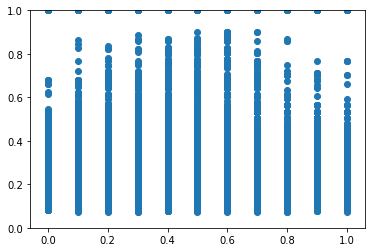

In [67]:
fig, axes = plt.subplots()
axes.scatter(long_form['exp'][0:100000], tm_score_domain[0:100000])
axes.set_ylim([0,1])
plt.show()

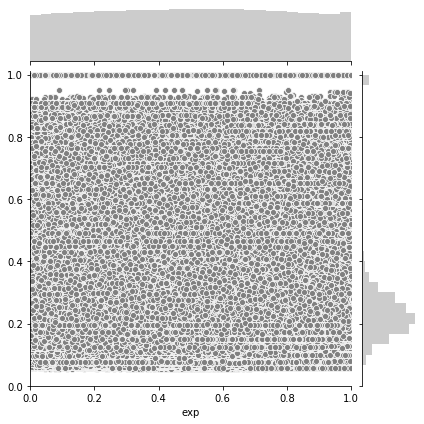

In [40]:
import matplotlib.pyplot as plt
g = sns.JointGrid(x=long_form['exp'], y=tm_score_domain, xlim=(0.0,1.0), ylim=(0.0,1.01))
g = g.plot_joint(sns.scatterplot, color=".5")
g = g.plot_marginals(sns.distplot, kde=False, color=".5", norm_hist=False, bins=30,  hist_kws={'range':(0.0,1)})

In [2]:
predicted_score = [8,9,9,8,8,6,5,5,3,2]
true_case = [0,1,1,1,1,1,0,0,0,0]
true_pos = [0,1,1,1,1,1,0,0,0,0]
true_neg = [1 if score==0 else 0 for score in true_pos]
df_trial = pd.DataFrame(list(zip(predicted_score, true_pos, true_neg)), columns =['predicted_score', 'true_pos', 'true_neg']) 


In [3]:
from lohia_utilities.calculate_auc import *
calc_auroc (df_trial,predicted_score='predicted_score')

0.9199999999999999

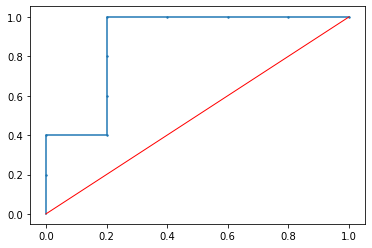

In [1550]:
df_trial = df_trial.sort_values(by=['predicted_score'], ascending=False)
df_trial['true_neg'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
df_trial['true_pos'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
df_trial['true_pos_cum'] = df_trial['true_pos'].cumsum()
df_trial['true_neg_cum'] = df_trial['true_neg'].cumsum()

fig, axes = plt.subplots()
axes.scatter([0] + df_trial['true_neg_cum'].values, [0] + df_trial['true_pos_cum'].values, s=2)
axes.plot([0] + df_trial['true_neg_cum'].tolist(), [0] + df_trial['true_pos_cum'].tolist())
#axes.set_ylim([0,1])
#axes.set_xlim([0,1])
axes.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.show()

In [1592]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_case, predicted_score)
metrics.roc_auc_score(true_case, predicted_score)

0.92

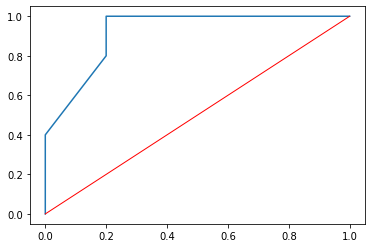

In [1594]:
fig, axes = plt.subplots()
#axes.scatter([0] + df_trial['true_neg_cum'].values, [0] + df_trial['true_pos_cum'].values, s=2)
axes.plot(fpr, tpr)
#axes.set_ylim([0,1])
#axes.set_xlim([0,1])
axes.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.show()

In [4]:
from sklearn import metrics
precision, recall, thresholds  = metrics.precision_recall_curve(true_case, predicted_score)
#metrics.roc_auc_score(true_case, predicted_score)

In [8]:
print (recall, precision)

[1.  0.8 0.4 0. ] [0.83333333 0.8        1.         1.        ]


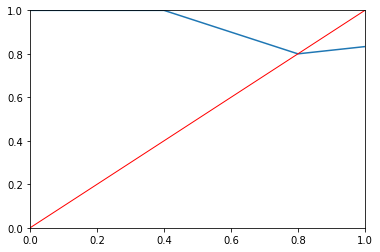

In [5]:
fig, axes = plt.subplots()
#axes.scatter([0] + df_trial['true_neg_cum'].values, [0] + df_trial['true_pos_cum'].values, s=2)
axes.plot(recall, precision)
axes.set_ylim([0,1])
axes.set_xlim([0,1])
axes.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.show()

In [1609]:
 metrics.f1_score(true_case, predicted_score, average='weighted')

0.0

In [6]:
df_trial = df_trial.sort_values(by=['predicted_score'], ascending=False)
df_trial = df_trial.reset_index()
#df_trial['true_neg'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
#df_trial['true_pos'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
df_trial['true_pos_cum'] = df_trial['true_pos'].cumsum()
df_trial['true_neg_cum'] = df_trial['true_neg'].cumsum()
df_trial['PPV'] = df_trial['true_pos_cum'] / (df_trial['true_pos_cum'] + df_trial['true_neg_cum'] )

df_trial['recall'] = df_trial['true_pos_cum']  / (df_trial['true_pos'].sum())
df_trial['f-score'] = (2 * df_trial['PPV'] * df_trial['recall']) / (df_trial['PPV'] + df_trial['recall'])
df_trial.iloc[df_trial['f-score'].idxmax()]

index              5.000000
predicted_score    6.000000
true_pos           1.000000
true_neg           0.000000
true_pos_cum       5.000000
true_neg_cum       1.000000
PPV                0.833333
recall             1.000000
f-score            0.909091
Name: 5, dtype: float64

In [1621]:
df_trial

index  predicted_score  true_pos  true_neg  true_pos_cum  true_neg_cum  \
0      1                9         1         0             1             0   
1      2                9         1         0             2             0   
2      0                8         0         1             2             1   
3      3                8         1         0             3             1   
4      4                8         1         0             4             1   
5      5                6         1         0             5             1   
6      6                5         0         1             5             2   
7      7                5         0         1             5             3   
8      8                3         0         1             5             4   
9      9                2         0         1             5             5   

        PPV  recall   f-score  
0  1.000000     0.2  0.333333  
1  1.000000     0.4  0.571429  
2  0.666667     0.4  0.500000  
3  0.750000     0.6  0.666667  
4  0.800000     0.8  0.800000  
5  0.833333     1.0  0.909091  
6  0.714286     1.0  0.833333  
7  0.625000     1.0  0.769231  
8  0.555556     1.0  0.714286  
9  0.500000     1.0  0.666667

index              5.000000
predicted_score    6.000000
true_pos           1.000000
true_neg           0.000000
true_pos_cum       5.000000
true_neg_cum       1.000000
PPV                0.833333
recall             1.000000
f-score            0.909091
Name: 5, dtype: float64

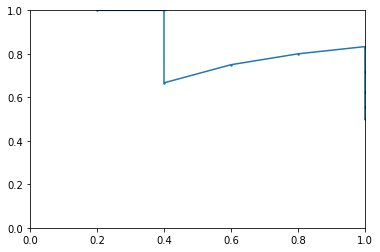

In [7]:
fig, axes = plt.subplots()
axes.scatter(df_trial['recall'], df_trial['PPV'], s=2)
axes.plot(df_trial['recall'], df_trial['PPV'])
axes.set_ylim([0,1])
axes.set_xlim([0,1])
#axes.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.show()

In [1559]:
sens = []
spec = []
scores = range(-10,12)
for score_threshold in scores:
    df_trial["exp_predicted"] = [1 if score >= score_threshold else 0 for score in df_trial["predicted_score"]]
    df_trial["exp_all"] = [1 if score > 0 else 0 for score in df_trial["true_pos"]]
    df_trial["mat"] = [1 if ((exp_predicted == exp_all) & (exp_predicted == 1)) else -1 if ((exp_predicted != exp_all) & (exp_predicted == 1)) else 2 if ((exp_predicted == exp_all) & (exp_predicted == 0)) else -2 for exp_predicted, exp_all in zip(df_trial["exp_predicted"], df_trial["exp_all"])]
    try:
        T_P = df_trial['mat'].value_counts()[1] 
    except KeyError:
        T_P = 0
    try:
        F_N = df_trial['mat'].value_counts()[-2] 
    except KeyError:
        F_N = 0
    try:
        T_N = df_trial['mat'].value_counts()[2] 
    except KeyError:
        T_N = 0
    try:
        F_P = df_trial['mat'].value_counts()[-1] 
    except KeyError:
        F_P = 0
    sensitivity = T_P / (T_P + F_N)
    specificity = (F_P / (F_P + T_N))
    sens.append(sensitivity)
    spec.append(specificity)

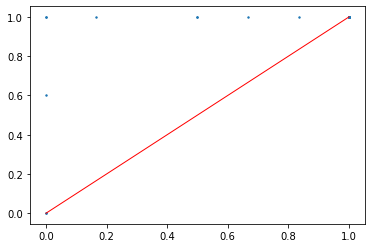

In [1172]:
fig, axes = plt.subplots()
axes.scatter(spec,sens,  s=2)
#axes.plot(spec, sens)
#axes.set_ylim([0,1])
#axes.set_xlim([0,1])
axes.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.show()

In [759]:
long_form = exp.unstack()
long_form.index.rename(['col_1', 'col_2'], inplace=True)
long_form = long_form.to_frame('exp').reset_index()
uni_list = merged_left['accession'].tolist()

In [760]:
long_form["tm_score"] = tm_score_domain

In [761]:
long_form_top = long_form[long_form["tm_score"] >= 0.25]

In [762]:
rank(long_form_top["tm_score"].to_numpy())

In [763]:
rank(long_form_top['exp'].to_numpy())

In [464]:
long_form_top

col_1   col_2       exp  tm_score
0         Q7Z5M8  Q7Z5M8  0.999821  1.000000
16        Q7Z5M8  Q8IUR6  0.094268  0.193794
18        Q7Z5M8  O60347  0.199853  0.353946
24        Q7Z5M8  Q8WUA4  0.095362  0.807595
25        Q7Z5M8  Q9H4Y5  0.347775  0.806567
...          ...     ...       ...       ...
32205620  A4QPB2  Q13495  0.382720  0.346959
32205621  A4QPB2  Q2TB10  0.477580  0.346959
32205622  A4QPB2  Q6UVK1  0.208789  0.517516
32205623  A4QPB2  Q9BZH6  0.558291  0.982217
32205624  A4QPB2  A4QPB2  0.999821  1.000000

[16170645 rows x 4 columns]

In [1388]:
long_form = exp.unstack()
long_form.index.rename(['col_1', 'col_2'], inplace=True)
long_form = long_form.to_frame('exp').reset_index()
long_form["tm_score"] = tm_score_domain


In [1056]:
long_form_top = long_form[long_form["tm_score"] >= 0.0]

In [1083]:
top_500_all_at_once_score_auroc_0_9 = []
top_500_all_at_once_score_auroc_0_7 = []
top_500_all_at_once_score_auroc_0_4 = []
top_500_all_at_once_score_auroc_0_5 = []
m_l_c = [top_500_all_at_once_score_auroc_0_9, top_500_all_at_once_score_auroc_0_7, top_500_all_at_once_score_auroc_0_5, top_500_all_at_once_score_auroc_0_4]

for (m_l, sim_thresh) in zip([top_500_all_at_once_score_auroc_0_9, top_500_all_at_once_score_auroc_0_7, top_500_all_at_once_score_auroc_0_5, top_500_all_at_once_score_auroc_0_4], [0.9, 0.7, 0.5,0.4]):
    #for i in range(0,5675):
        
        long_form_top = long_form_top[long_form_top["tm_score"] >= 0.0]
        long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)
        long_form_top = long_form_top.head(500)
        #rank(long_form_top["tm_score"].to_numpy())
        #rank(long_form_top['exp'].to_numpy())
        long_form_top["True_sim"] = [1 if score >= sim_thresh else 0 for score in long_form_top["tm_score"]]
        long_form_top["true_pos"] = [score for score in long_form_top["True_sim"]]
        long_form_top["true_neg"] = [1 if score==0 else 0 for score in long_form_top["True_sim"]]
        long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp"]]
        ca = calc_auroc (long_form_top,predicted_score='predicted_sim_from_exp')
        m_l.append(ca)

In [1032]:
top_all_all_at_once_score_auroc_0_9

[0.5477260496970955]

In [1389]:
prot_list_sp = np.array_split(long_form, 5675, axis=0)

In [2081]:
def prec_recall (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial = df_trial.reset_index()
    #df_trial['true_neg'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    #df_trial['true_pos'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg'].cumsum()
    df_trial['PPV'] = df_trial['true_pos_cum'] / (df_trial['true_pos_cum'] + df_trial['true_neg_cum'] )
    df_trial['recall'] = df_trial['true_pos_cum']  / (df_trial['PPV'].sum())
    #df_trial['recall'] = df_trial['recall'].round(1)
    #df_trial['f-score'] = (2 * df_trial['PPV'] * df_trial['recall']) / (df_trial['PPV'] + df_trial['recall'])
    #df_trial.iloc[df_trial['f-score'].idxmax()]
    return dict(zip(df_trial['recall'].tolist(), df_trial['PPV'].tolist()))



def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
        
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()
    
def calc_auc_curve (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial['true_neg'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    df_trial['true_pos'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg'].cumsum()
    #df_trial['true_neg_cum'] = df_trial['true_neg_cum'].round(1)
    return dict(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))

    #fig, axes = plt.subplots()
    #axes.scatter([0] + df_trial['true_neg_cum'].values, [0] + df_trial['true_pos_cum'].values)
    #axes.plot([0] + df_trial['true_neg_cum'].tolist(), [0] + df_trial['true_pos_cum'].tolist())
    ##axes.set_ylim([0,1])
    ##axes.set_xlim([0,1])
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #plt.show()

In [2299]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
m_l = []
for sim_thresh in [x*0.1 for x in [8]]:
    for i in range(0,5675):

        long_form_top = prot_list_sp[int(i)]
        long_form_top = long_form_top[long_form_top["tm_score"] >= 0.0]

        #print (long_form_top)
        long_form_top = long_form_top[long_form_top['col_1'] != long_form_top['col_2']]
        try: 
           mp =  long_form_top['col_1'].values[0]
        except IndexError:
           mp = ''
        #print (long_form_top['col_1'].values[0])
        #long_form_top = long_form_top[long_form_top["tm_score"] <= 0.98]
        #long_form_top = long_form_top[long_form_top["exp"] >= 0.7]

        long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
        long_form_top = long_form_top.reset_index()
        #print ("here")
        #long_form_top = long_form_top.head(100)
        
        #rank(long_form_top["tm_score"].to_numpy())
        #rank(long_form_top['exp'].to_numpy())
        long_form_top["True_sim"] = [1 if score >= sim_thresh else 0 for score in long_form_top["tm_score"]]
        #long_form_top["True_sim"] = long_form_top["tm_score"] * 0
        #long_form_top["True_sim"][0:9] = long_form_top["True_sim"][0:9] + 1 
        #long_form_top["True_sim"][0:9] = (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
        #print (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
        #print (long_form_top["True_sim"])
        #the top ten macthes are considered TP
        #print (long_form_top)
        #rank_abs = lambda x: stats.rankdata(np.abs(x))
        #predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[long_form_top].values)
        
        long_form_top["true_pos"] = [score for score in long_form_top["True_sim"]]
        long_form_top["true_neg"] = [1 if score==0 else 0 for score in long_form_top["True_sim"]]
        #print (long_form_top["true_pos"].sum())
        #print (long_form_top["true_neg"].sum())
        long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp"]]
        #print ("here2")
        
        ca = calc_auroc (long_form_top,predicted_score='predicted_sim_from_exp')
        m_curve = calc_auc_curve (long_form_top,predicted_score='predicted_sim_from_exp')
        pr_curve = prec_recall (long_form_top,predicted_score='predicted_sim_from_exp')
        
        m_l.append((sim_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp))

In [5]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name'])
df_scores.dropna(inplace=True)
df_scores['threshold'] = df_scores['threshold'].round(2)
df_scores = df_scores[df_scores['threshold']==0.8]

NameError: name 'pd' is not defined

In [4]:
df_scores

NameError: name 'df_scores' is not defined

In [1955]:
df_scores['sum'] = df_scores['true_pos'] + df_scores['true_neg']

In [1959]:
gp = df_scores.groupby('sum')
gp.groups.keys()

dict_keys([5597.0])

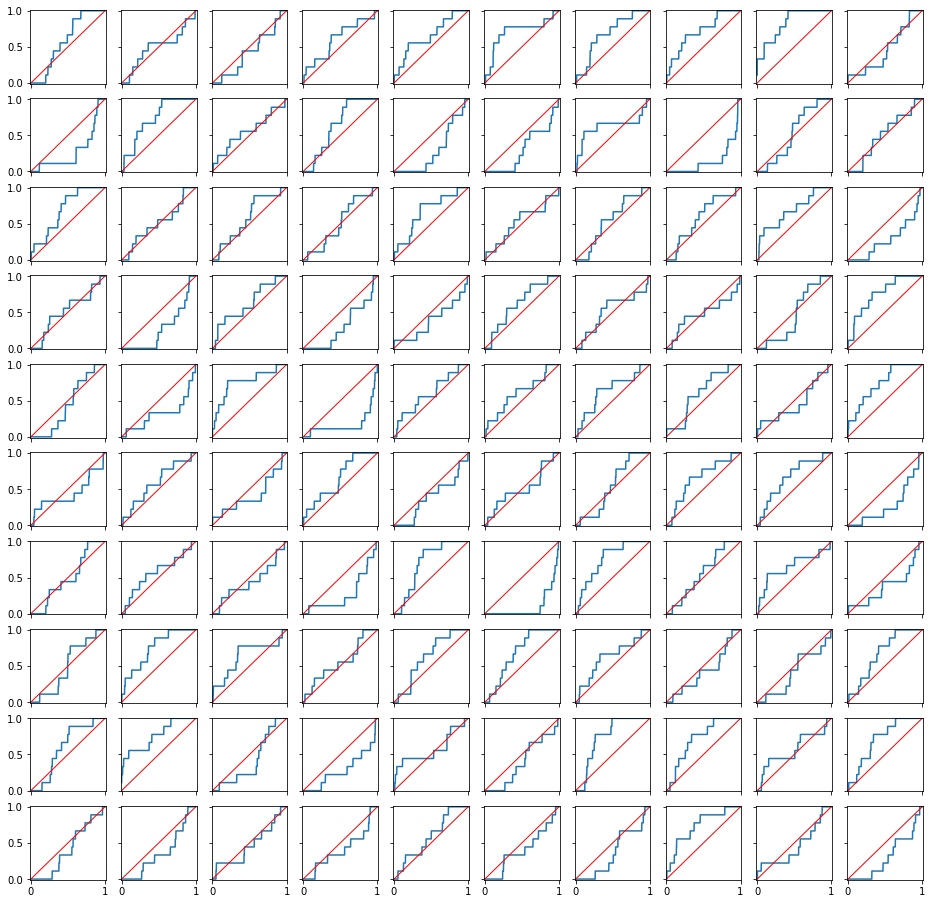

In [2105]:
fig, axes = plt.subplots(10,10, sharex=True, sharey=True)
for thresh, ax  in zip(range(0,100), axes.flatten()):    
    df_plot = df_scores.iloc[thresh]
    ax.plot(*zip(*sorted(df_plot['plot'].items())))
    #df_plot = pd.concat([df_plot.drop(['plot'], axis=1), df_plot['plot'].apply(pd.Series)], axis=1)
    #ax = df_plot.T.reset_index().plot(x='index', y=thresh)
    ax.plot([0, 1], [0, 1], 'red', linewidth=1)
    #ax = df_plot.T.reset_index().plot(x='index', y=0.3)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
ax.set_ylim([-0.01,1.01])
ax.set_xlim([-0.01,1.01])
fig.set_size_inches(16,16)
#plt.show()
plt.show()

In [2301]:
df_scores = pd.concat([df_scores.drop(['plot'], axis=1), df_scores['plot'].apply(pd.Series)], axis=1)

In [3]:
df_scores

NameError: name 'df_scores' is not defined

In [2297]:
#df_plot = df_scores.groupby(['threshold']).mean()

In [ ]:
y = df_scores.T.reset_index()[6::]

In [ ]:
y = y.astype(float)

In [ ]:
y['x_p'] = y['index'].astype(float).round(2)

In [ ]:
z = y.groupby(['x_p']).mean()

In [ ]:
z.drop(columns=['index'], inplace=True)

In [ ]:
zt = z.mean(axis=1)

In [1740]:
g = df_plot.T.reset_index()
g['f-score'] = (2 * g[0.4] * g['index']) / (g[0.4] + g['index'])
    #df_trial.iloc[df_trial['f-score'].idxmax()]

In [ ]:
for thresh in df_plot.index.tolist():
    #axes = df_plot.T.reset_index()[4::].plot.scatter(x='index', y=thresh, s=1)
    axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

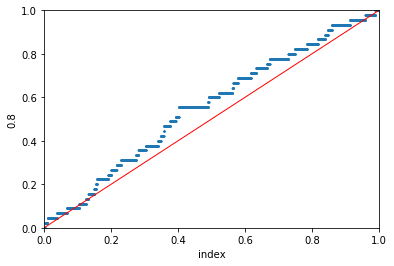

In [2298]:
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[4::].plot.scatter(x='index', y=thresh, s=1)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

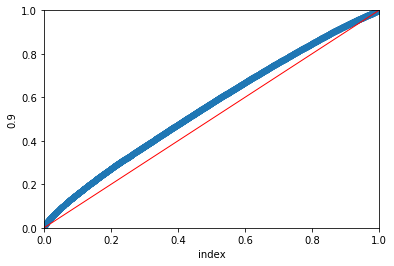

In [2057]:
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[4::].plot.scatter(x='index', y=thresh)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

In [ ]:
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index().plot.scatter(x='index', y=thresh)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

In [1754]:
df_scores = df_scores[df_scores['threshold'] == 0.4]

In [1818]:
df_scores

threshold       auc                                               plot  \
17025        0.5  0.480046  {0.0: 0.03225806451612903, 0.1: 0.032258064516...   
17027        0.5  0.489995  {0.0: 0.024096385542168676, 0.1: 0.08433734939...   
17028        0.5  0.534554  {0.0: 0.0273972602739726, 0.1: 0.1095890410958...   
17029        0.5  0.533487  {0.0: 0.07810650887573976, 0.1: 0.207100591715...   
17030        0.5  0.614775  {0.0: 0.12903225806451613, 0.1: 0.387096774193...   
...          ...       ...                                                ...   
45395        0.9  0.579164  {0.0: 0.10739856801909291, 0.1: 0.255369928400...   
45396        0.9  0.521011  {0.0: 0.0739856801909307, 0.1: 0.1766109785202...   
45397        0.9  0.436626  {0.0: 0.06451612903225806, 0.1: 0.129032258064...   
45398        0.9  0.730248  {0.0: 0.1111111111111111, 0.1: 0.3968253968253...   
45399        0.9  0.388119  {0.0: 0.0, 0.1: 0.0, 0.2: 0.0, 0.3: 0.25, 0.4:...   

                                                pr_curve  true_pos  true_neg  \
17025  {0.0: 0.00089126559714795, 0.1: 0.002332814930...      31.0    5566.0   
17027  {0.0: 0.006741573033707865, 0.1: 0.00966183574...      83.0    5514.0   
17028  {0.0: 0.015590200445434299, 0.1: 0.02052785923...     146.0    5451.0   
17029  {0.0: 0.20982142857142858, 0.1: 0.203147353361...     845.0    4752.0   
17030  {0.0: 0.029411764705882353, 0.1: 0.01699029126...      31.0    5566.0   
...                                                  ...       ...       ...   
45395  {0.0: 0.27225130890052357, 0.1: 0.268707482993...     838.0    4759.0   
45396  {0.0: 0.2358974358974359, 0.1: 0.1906077348066...     838.0    4759.0   
45397  {0.0: 0.0051813471502590676, 0.1: 0.0035746201...      31.0    5566.0   
45398  {0.0: 0.03048780487804878, 0.1: 0.025723472668...      63.0    5534.0   
45399  {0.0: 0.0, 0.4: 0.00029282576866764275, 0.9: 0...       4.0    5593.0   

      prot_name  tp_frac  
17025    Q7Z5M8      0.0  
17027    P21941      0.0  
17028    Q9UQB9      0.0  
17029    P35637      0.2  
17030    Q96IU4      0.0  
...         ...      ...  
45395    Q13495      0.1  
45396    Q2TB10      0.1  
45397    Q6UVK1      0.0  
45398    Q9BZH6      0.0  
45399    A4QPB2      0.0  

[25724 rows x 8 columns]

In [2126]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name'])
df_scores.dropna(inplace=True)
df_scores['threshold'] = df_scores['threshold'].round(2)

df_scores['tp_frac'] = (df_scores['true_pos']* 1.0)/ (df_scores['true_neg']+df_scores['true_pos'] )
df_scores['avg_tp_freq']= df_scores.groupby(['threshold'])['tp_frac'].transform('mean')
#df_scores['freq'] = df_scores['freq']/df_scores.shape[0]

In [1870]:
#df_scores['tp_frac'] = df_scores['tp_frac'].round(1)
#df_scores = df_scores[df_scores['threshold'] == 0.5]

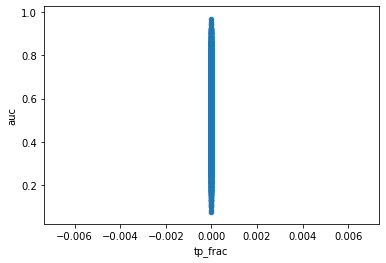

In [2127]:
df_scores.drop_duplicates(subset=['tp_frac', 'prot_name'], inplace=True)
df_scores['tp_frac'] = df_scores['tp_frac'].round(1)
df_scores['freq']= df_scores.groupby(['tp_frac'])['auc'].transform('count')
df_scores['freq'] = df_scores['freq']/df_scores.shape[0]
df_scores.plot.scatter(x='tp_frac', y = 'auc')

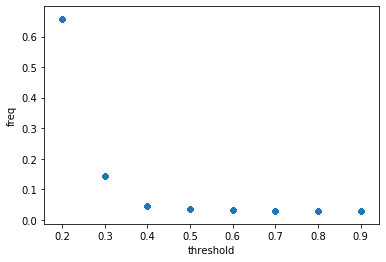

In [1872]:
df_scores.plot.scatter(x='threshold', y = 'freq')

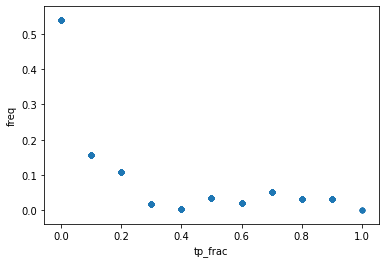

In [1876]:
df_scores.plot.scatter(x='tp_frac', y = 'freq')

In [1858]:
df_scores = df_scores[df_scores['threshold'] == 0.8]

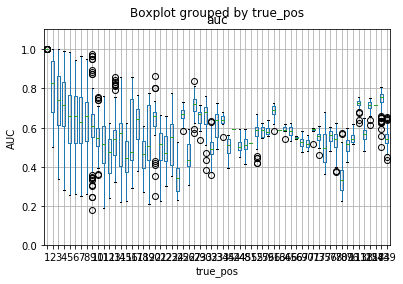

In [1750]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='true_pos', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

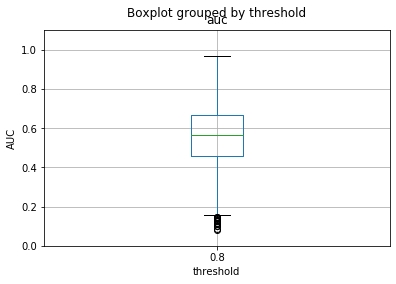

In [2128]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='threshold', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

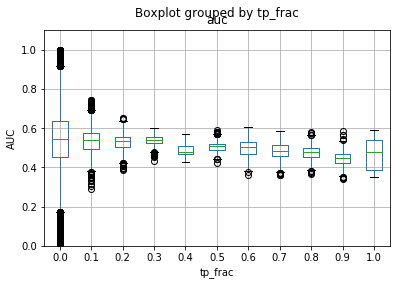

In [1877]:
fig, axes = plt.subplots()
grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='tp_frac', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

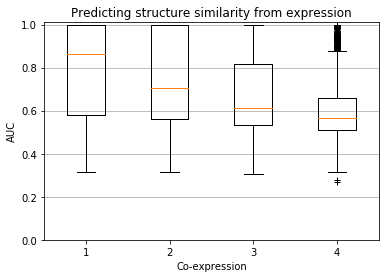

In [1088]:
fig, axes = plt.subplots()
bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0,1.01])
axes.set_ylim([0,1.01])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

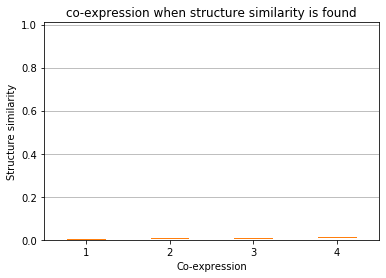

In [1084]:
fig, axes = plt.subplots()

bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_all_at_once_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_all_at_once_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_all_at_once_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_all_at_once_score_auroc_0_4]] , sym='k+')
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
axes.set_title('co-expression when structure similarity is found')
axes.yaxis.grid(True)
axes.set_xlabel('Co-expression')
axes.set_ylabel('Structure similarity')
axes.set_ylim([0,1.01])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [1090]:
top_all_all_at_once_score_auroc_0_9

[0.5477260496970955]

In [1091]:
top_all_all_at_once_score_auroc_0_7

[0.5487910705116246]

In [1092]:
top_all_all_at_once_score_auroc_0_5

[0.5441030448925607]

In [1093]:
top_all_all_at_once_score_auroc_0_4

[0.5483776630183521]

In [1065]:
~np.isnan(top_all_score_auroc_0_9)

array([ True,  True,  True, ...,  True,  True,  True])

0.8859180154884205
0.7797427652733119
0.861731903857421
0.7386566630939622
0.8194734487821937
0.6600571632725973
0.7643413160776302
0.5498392282958199


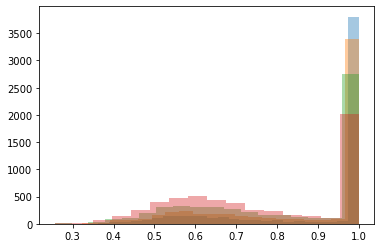

In [1044]:
#m_l_c = [top_100_score_auroc_0_9]
m_l_c = [top_50_score_auroc_0_9, top_50_score_auroc_0_7, top_50_score_auroc_0_5, top_50_score_auroc_0_4]
for i in m_l_c:
    print (np.nansum(i, axis=0)/np.count_nonzero(~np.isnan(i)))
    sns.distplot(i, hist=True, kde=False)
    print (sum([1 if 0.7<x else 0 for x in i])/np.count_nonzero(~np.isnan(i)))

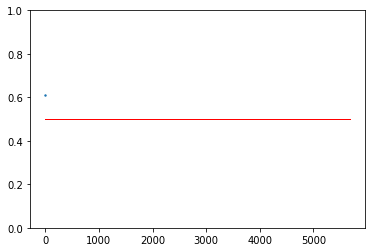

In [1242]:

fig, axes = plt.subplots()
axes.scatter(range(0,len(top_1000_score_auroc_0_9)), top_1000_score_auroc_0_9,  s=2)
#axes.plot(spec, sens)
#axes.set_ylim([0,1])
axes.set_ylim([0,1])
axes.plot([0, 5675], [0.5,0.5], 'red', linewidth=1)
plt.show()

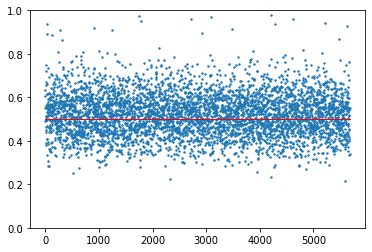

In [920]:
fig, axes = plt.subplots()
axes.scatter(range(0,5675), top_100_score_auroc,  s=2)
#axes.plot(spec, sens)
#axes.set_ylim([0,1])
axes.set_ylim([0,1])
axes.plot([0, 5675], [0.5,0.5], 'red', linewidth=1)
plt.show()

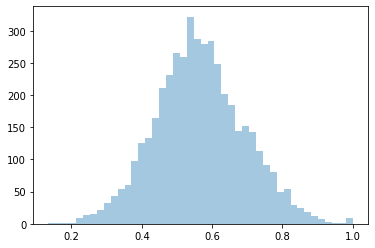

In [984]:
sns.distplot(top_100_score_auroc, hist=True, kde=False)

In [983]:
sum([1 if x>0.7 else 0 for x in top_100_score_auroc])/np.count_nonzero(~np.isnan(top_100_score_auroc))

0.15032243718034244

In [979]:
np.nansum(top_100_score_auroc, axis=0)/4000

0.6348751121423638

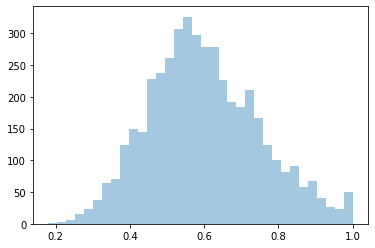

In [931]:
sns.distplot(top_100_score_auroc, hist=True, kde=False)

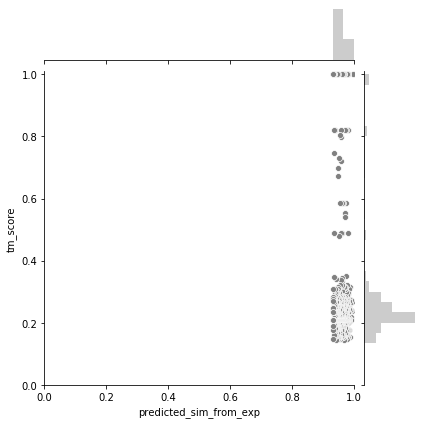

In [1290]:
import matplotlib.pyplot as plt
g = sns.JointGrid(x=long_form_top['predicted_sim_from_exp'], y=long_form_top['tm_score'], xlim=(0.0,1.0), ylim=(0.0,1.01))
g = g.plot_joint(sns.scatterplot, color=".5")
g = g.plot_marginals(sns.distplot, kde=False, color=".5", norm_hist=False, bins=30,  hist_kws={'range':(0.0,1)})

In [764]:
#making the ROC curve manually:
long_form_top["True_sim"] = [1 if score >= 0.3 else 0 for score in long_form_top["tm_score"]]
long_form_top["True_sim_pos"] = [score for score in long_form_top["True_sim"]]
long_form_top["True_sim_neg"] = [1 if score==0 else 0 for score in long_form_top["True_sim"]]
long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp"]]


/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [765]:
long_form_top = long_form_top.sort_values(by=['predicted_sim_from_exp'], ascending=False)

In [766]:
long_form_top['True_sim_neg'] = long_form_top['True_sim_neg']/ long_form_top['True_sim_neg'].sum()
long_form_top['True_sim_pos'] = long_form_top['True_sim_pos']/ long_form_top['True_sim_pos'].sum()

In [767]:
long_form_top['True_sim_pos_cum'] = long_form_top['True_sim_pos'].cumsum()

In [768]:
long_form_top['True_sim_neg_cum'] = long_form_top['True_sim_neg'].cumsum()

/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [509]:
long_form_top['True_sim_neg_cum']

0                 0
1                 1
2                 1
3                 1
5                 1
             ...   
32205616    5412092
32205617    5412092
32205619    5412093
32205623    5412093
32205624    5412093
Name: True_sim_neg_cum, Length: 11223397, dtype: int64

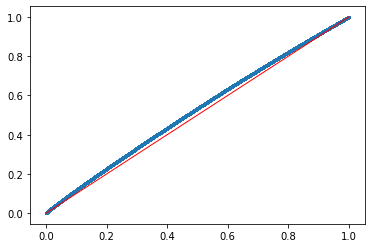

In [769]:
fig, axes = plt.subplots()
axes.scatter(long_form_top['True_sim_neg_cum'].values, long_form_top['True_sim_pos_cum'].values, s=2)
#axes.plot(spec, sens)
#axes.set_ylim([0,1])
#axes.set_xlim([0,1])
axes.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.show()

In [592]:
sens = []
spec = []
scores = np.linspace(0.0,1.0,5)

In [593]:
for score_threshold in scores:
    long_form_top["exp_predicted"] = [1 if score >= score_threshold else 0 for score in long_form_top["exp"]]
    long_form_top["exp_all"] = [1 if score >= 0.8 else 0 for score in long_form_top["tm_score"]]
    long_form_top["mat"] = [1 if ((exp_predicted == exp_all) & (exp_predicted == 1)) else -1 if ((exp_predicted != exp_all) & (exp_predicted == 1)) else 2 if ((exp_predicted == exp_all) & (exp_predicted == 0)) else -2 for exp_predicted, exp_all in zip(long_form_top["exp_predicted"], long_form_top["exp_all"])]
    try:
        T_P = long_form_top['mat'].value_counts()[1] 
    except KeyError:
        T_P = 0
    try:
        F_N = long_form_top['mat'].value_counts()[-2] 
    except KeyError:
        F_N = 0
    try:
        T_N = long_form_top['mat'].value_counts()[2] 
    except KeyError:
        T_N = 0
    try:
        F_P = long_form_top['mat'].value_counts()[-1] 
    except KeyError:
        F_P = 0
    sensitivity = T_P / (T_P + F_N)
    specificity = (F_P / (F_P + T_N))
    sens.append(sensitivity)
    spec.append(specificity)

/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


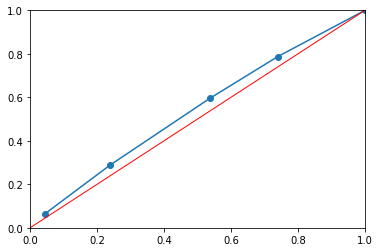

In [594]:
fig, axes = plt.subplots()
axes.scatter(spec, sens)
axes.plot(spec, sens)
axes.set_ylim([0,1])
axes.set_xlim([0,1])
axes.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.show()

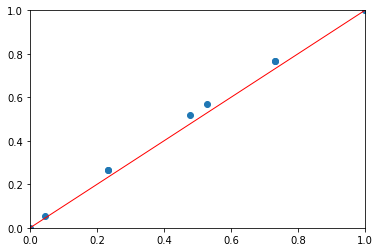

In [431]:
fig, axes = plt.subplots()
axes.scatter(spec, sens)
axes.set_ylim([0,1])
axes.set_xlim([0,1])
axes.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.show()

In [150]:
import numpy as np
import bottleneck
import gc

def rank(data):
    """Rank normalize data
    
    Rank standardize inplace 
    Ignores Nans and replace with .5
    
    Does not return 
    Arguments:
        data {np.array} -- Array of data
    
    """
    #finite = np.isfinite(data)
    ranks = bottleneck.rankdata(data)

    ranks -= 1
    top = np.max(ranks)
    ranks /= top
    #data[...] = .5
    np.putmask(data, data, ranks)
    del ranks

In [151]:
rank(long_form_top["tm_score"].to_numpy())

In [503]:
long_form_top['exp'] =  long_form_top['exp'].apply(lambda x: round(x,1))

/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


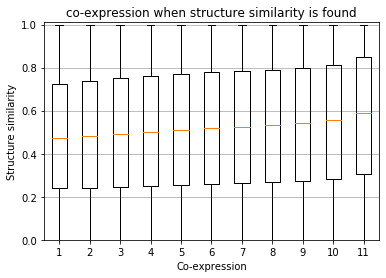

In [504]:
fig, axes = plt.subplots()
bp = axes.boxplot([long_form_top[long_form_top.exp == 0.0]["tm_score"].values,
                           long_form_top[long_form_top.exp == 0.1]["tm_score"].values,
                           long_form_top[long_form_top.exp == 0.2]["tm_score"].values,
                           long_form_top[long_form_top.exp == 0.3]["tm_score"].values,
                           long_form_top[long_form_top.exp == 0.4]["tm_score"].values,
                           long_form_top[long_form_top.exp == 0.5]["tm_score"].values,
                           long_form_top[long_form_top.exp == 0.6]["tm_score"].values,
                           long_form_top[long_form_top.exp == 0.7]["tm_score"].values,
                           long_form_top[long_form_top.exp == 0.8]["tm_score"].values,
                           long_form_top[long_form_top.exp == 0.9]["tm_score"].values,
                           long_form_top[long_form_top.exp == 1.0]["tm_score"].values] , sym='k+')
axes.set_title('co-expression when structure similarity is found')
axes.yaxis.grid(True)
axes.set_xlabel('Co-expression')
axes.set_ylabel('Structure similarity')
axes.set_ylim([0,1.01])
plt.setp(bp['fliers'], markersize=3.0)

plt.show()

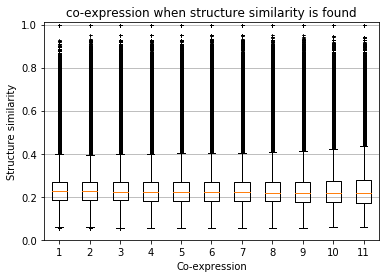

In [68]:
fig, axes = plt.subplots()
bp = axes.boxplot([long_form[long_form.exp == 0.0]["tm_score"].values,
                           long_form[long_form.exp == 0.1]["tm_score"].values,
                           long_form[long_form.exp == 0.2]["tm_score"].values,
                           long_form[long_form.exp == 0.3]["tm_score"].values,
                           long_form[long_form.exp == 0.4]["tm_score"].values,
                           long_form[long_form.exp == 0.5]["tm_score"].values,
                           long_form[long_form.exp == 0.6]["tm_score"].values,
                           long_form[long_form.exp == 0.7]["tm_score"].values,
                           long_form[long_form.exp == 0.8]["tm_score"].values,
                           long_form[long_form.exp == 0.9]["tm_score"].values,
                           long_form[long_form.exp == 1.0]["tm_score"].values] , sym='k+')
axes.set_title('co-expression when structure similarity is found')
axes.yaxis.grid(True)
axes.set_xlabel('Co-expression')
axes.set_ylabel('Structure similarity')
axes.set_ylim([0,1.01])
plt.setp(bp['fliers'], markersize=3.0)

plt.show()

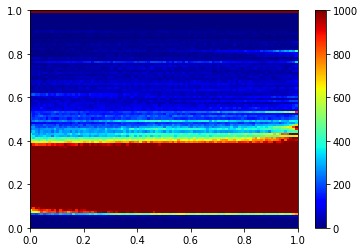

In [64]:
from matplotlib.colors import Normalize
plt.hist2d(long_form['exp'], long_form['tm_score'], (100, 100), cmap=plt.cm.jet, vmin=0, vmax= 1000,range=[[0, 1], [0, 1]])
plt.colorbar()

7.731110432920923e-09

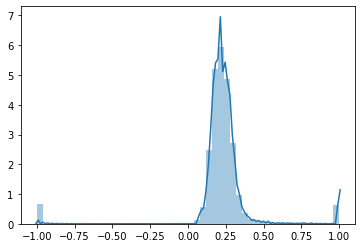

In [37]:
sns.distplot(tm_score_domain, hist=True, kde=True)
exp.min().min()

In [31]:
tm_score_domain

[1.0,
 0.2754,
 0.46771,
 0.30268,
 0.19561,
 1.0,
 0.19561,
 0.22795,
 0.25521,
 0.24881,
 0.22387,
 0.22824,
 0.32032,
 0.24287,
 0.23836,
 0.35748,
 0.16519,
 0.23836,
 0.19561,
 0.30486,
 0.19561,
 0.23281,
 0.42669,
 0.22873,
 0.28203,
 0.28176,
 0.19561,
 0.19561,
 0.32876,
 0.23895,
 0.26517,
 0.28494,
 0.28203,
 0.27489,
 0.2561,
 0.28909,
 0.27045,
 0.30215,
 0.34152,
 0.12811,
 0.26129,
 0.30704,
 0.22298,
 0.26223,
 -1.0,
 0.29934,
 0.2561,
 0.26562,
 0.22837,
 0.3314,
 0.12811,
 0.31512,
 0.29891,
 0.28862,
 0.24889,
 0.2313,
 0.46312,
 0.37068,
 0.34897,
 0.19561,
 0.2675,
 0.29968,
 0.29643,
 0.42669,
 0.24444,
 0.22664,
 0.26885,
 0.19561,
 0.44723,
 0.20895,
 0.30704,
 0.23527,
 0.19561,
 -1.0,
 0.20895,
 0.2605,
 0.19561,
 0.26784,
 0.27723,
 0.45493,
 0.31097,
 0.19515,
 0.12811,
 0.26776,
 0.23409,
 0.3541,
 0.18795,
 0.25551,
 0.3448,
 0.19561,
 0.25363,
 0.30816,
 0.24959,
 0.33463,
 0.22837,
 0.30034,
 0.23551,
 0.27575,
 0.20895,
 0.12811,
 0.2456,
 0.30219,
 0.2